## 함수 정의

In [279]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def auto_canny_otsu(image, ksize=(5, 5)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    high_thresh, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5 * high_thresh
    # Canny 엣지 검출 적용
    blur = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blur, low_thresh, high_thresh)
    return edged

def get_angle(line):
    x1, y1, x2, y2 = line[0]
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

def get_midpoint(line):
    x1, y1, x2, y2 = line[0]
    return ((x1 + x2) / 2, (y1 + y2) / 2)

def get_line_length(line):
    x1, y1, x2, y2 = line[0]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def distance_between_points(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def filter_lines(lines, angle_threshold, dist_threshold):
    filtered_lines = []
    used = [False] * len(lines)

    for i in range(len(lines)):
        if not used[i]:
            max_length = get_line_length(lines[i])
            selected_line = lines[i]
            angle_i = get_angle(lines[i])
            midpoint_i = get_midpoint(lines[i])
            used[i] = True

            for j in range(i + 1, len(lines)):
                if not used[j]:
                    angle_j = get_angle(lines[j])
                    if abs(angle_i - angle_j) <= angle_threshold:
                        midpoint_j = get_midpoint(lines[j])
                        if distance_between_points(midpoint_i, midpoint_j) < dist_threshold:
                            length = get_line_length(lines[j])
                            if length > max_length:
                                selected_line = lines[j]
                                max_length = length
                            used[j] = True
            filtered_lines.append(selected_line)

    return filtered_lines


def find_intersection(line1, line2):
    """ 두 선분의 교차점을 계산합니다. """
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    # 선분의 방정식으로부터 A, B, C 계수를 계산
    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1
    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    # 행렬식 계산
    determinant = A1 * B2 - A2 * B1
    if determinant == 0:
        # 두 선분이 평행인 경우
        return None
    else:
        # 교차점 계산
        x = (B2 * C1 - B1 * C2) / determinant
        y = (A1 * C2 - A2 * C1) / determinant
        return int(x), int(y)

def find_new_points(old_frame, angle_threshold, dist_threshold):
    # 새로운 코너점을 검출하는 함수
    edges = auto_canny_otsu(old_frame)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
                           maxLineGap=200)
    new_points = []
    if lines is not None :
        filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            new_points.append([x1, y1])
            new_points.append([x2, y2])
#             print("line[0]:",line[0])
#             angle = get_angle(line)              
            
#             for i in range(len(lines)):
#                 for j in range(i + 1, len(lines)):
#                     intersect = find_intersection(lines[i], lines[j])
#                     if intersect:
#                         new_points.append(intersect)
                        
        lines = filtered_lines.copy()
#     np.array(new_points, dtype=np.float32).reshape(-1, 1, 2)
    return new_points, lines

def is_point_on_valid_line(point, lines, threshold=10): # threshold=10
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist = cv2.pointPolygonTest(np.array([[x1, y1], [x2, y2]]), (point[0], point[1]), True)
#         result = cv2.pointPolygonTest(np.array([[x1, y1], [x2, y2]]), (point[0], point[1]), False)
#         if dist == -1 or dist == 0 :
#             return True
        if abs(dist) < threshold:
            return True
    return False

def remove_close_points(points, threshold):
    valid_points = []
    for i, point in enumerate(points):
        too_close = False
        for j, other_point in enumerate(points):
            if i != j and distance_between_points(point, other_point) < threshold:
                too_close = True
                break
        if not too_close:
            valid_points.append(point)
    return np.array(valid_points)

## corner points tracking 실행 (optical flow)

In [293]:
lk_params = dict(winSize=(17, 17), maxLevel=2, 
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                           10, 0.03))

angle_threshold = 15  # 중복제거 선 각도 임계
dist_threshold = 70   # 중복제거 선 거리 임계
threshold_distance = 30 # 중복제거 점간 거리 임계

In [244]:
cap = cv2.VideoCapture(1)

In [294]:
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0, _ = find_new_points(old_frame, angle_threshold, dist_threshold)

# print(p0)
threshold_distance = 30  # 너무 가까운 점 제거
p0 = np.array(p0,dtype=np.float32)
p0 = remove_close_points(p0, threshold_distance)
frame_idx = 0
height, width = old_gray.shape

# 프레임 밖으로 나간 포인트 제거
inside_frame = (p0[:, 0] > 0) & (p0[:, 0] < frame.shape[1]) & \
               (p0[:, 1] > 0) & (p0[:, 1] < frame.shape[0])
p0 = p0[inside_frame]
p0 = np.array(p0, dtype=np.float32).reshape(-1, 1, 2)
print("초기 시작점 개수 :",len(p0))

초기 시작점 개수 : 15


In [298]:
import time
while True:
    ret, frame = cap.read()
    start = time.time()
    if not ret:
        break
    window = frame.copy()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = auto_canny_otsu(frame)
     # 옵티컬 플로우 계산
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # 좋은 추적 포인트 선택
    good_new = p1[st == 1].reshape(-1, 2)
    good_old = p0[st == 1].reshape(-1, 2)
    
    # 일정 간격으로 새로운 포인트 추가
#     if len(good_new) < 50 or frame_idx % 30 == 0  : # frame_idx % 30 == 0 
    new_p, lines = find_new_points(frame, angle_threshold, dist_threshold)
    new_p =  np.array(new_p, dtype=np.float32).reshape(-1, 1, 2)
    if len(new_p) > 0:
        new_p = new_p.reshape(-1, 2)  # new_p를 2차원 배열로 변환
        good_new = np.vstack((good_new, new_p))  # 배열을 연결   
            
    # 프레임 밖으로 나간 포인트 제거
    inside_frame = (good_new[:, 0] > 0) & (good_new[:, 0] < frame.shape[1]) & \
                   (good_new[:, 1] > 0) & (good_new[:, 1] < frame.shape[0])
    good_new = good_new[inside_frame]
            
    valid_points = [] # 유효한 포인트만 필터링
            
    for point in good_new:
        if is_point_on_valid_line(point, lines):
            valid_points.append(point)
            
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            intersect = find_intersection(lines[i], lines[j])
            if intersect:
                valid_points.append(intersect)
            
    # 근접 포인트 제거 
    valid_points = np.array(valid_points)
    valid_points = remove_close_points(valid_points, threshold_distance)
    
#     print("number of valid points :",len(valid_points))
    
    # 포인트 추적 시각화
    for point in valid_points :
        a, b = point.ravel()
        a, b = int(a), int(b)
        cv2.circle(window, (a, b), 5, (0, 255, 0), -1)
    
    
#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
#                            maxLineGap=200)
    
#     if lines is not None :
#         filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
#     print(f"processing time : {time.time() - start :.2f}")
    
    if lines is not None :
        for line in lines :
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(window, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(window, (x1, y1), (x2, y2), (255,0, 0), 3)   
    
    cv2.imshow('Frame with Optical Flow', cv2.hconcat([window, cv2.cvtColor(edges,cv2.COLOR_GRAY2BGR)]))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
    # 현재 프레임과 포인트 업데이트
    old_gray = frame_gray.copy()
    p0 = np.array(valid_points, dtype=np.float32).reshape(-1, 1, 2)
#     print(p0)
#     print(p0.shape)
    frame_idx += 1
    
# cap.release()
cv2.destroyAllWindows()

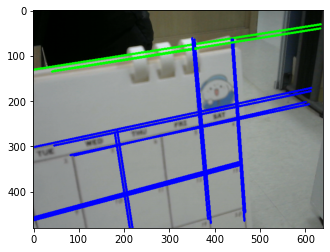

In [288]:
ret, frame = cap.read()

edges = auto_canny_otsu(frame)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
                       maxLineGap=150)

for line in lines :
    x1, y1, x2, y2 = line[0]
    angle = calculate_angle(x1, y1, x2, y2)               
    if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
        cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
    else :
        cv2.line(frame, (x1, y1), (x2, y2), (255,0, 0), 3)   
        
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

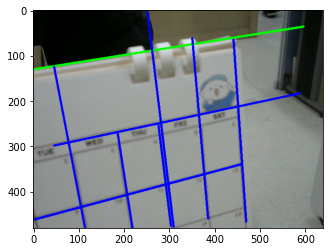

In [290]:
ret, frame = cap.read()

edges = auto_canny_otsu(frame)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=200,
                       maxLineGap=200)

for line in lines :
    filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(frame, (x1, y1), (x2, y2), (255,0, 0), 3)  
                
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

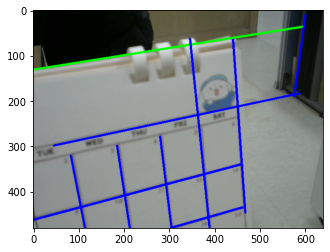

In [291]:
ret, frame = cap.read()

edges = auto_canny_otsu(frame)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=150,
                       maxLineGap=150)

for line in lines :
    filtered_lines = filter_lines(lines, angle_threshold, dist_threshold)
        
    if filtered_lines is not None :
        for line in filtered_lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_angle(x1, y1, x2, y2)               
            if -10 <= angle <= 10 or 170 <= angle <= 180 or -180 <= angle <= -170:
                cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
            else :
                cv2.line(frame, (x1, y1), (x2, y2), (255,0, 0), 3)  
                
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

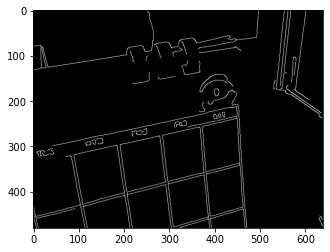

In [292]:
plt.imshow(edges, cmap='gray')